In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
import cv2
from pycocotools import mask
import pandas as pd
import json
from collections import defaultdict
from skimage import draw

In [2]:
!pwd

/mmdetection/demo


In [21]:
dataDir='../data/coco_datasets/datasets/merimen_coco/19_02_2022'
dataType='total'
annFile='{}/scratch/annotations/{}.json'.format(dataDir,dataType)

coco=COCO(annFile)


loading annotations into memory...
Done (t=2.23s)
creating index...
index created!


In [4]:
print(len(coco.anns), len(coco.imgs), len(coco.cats))

185348 90298 1


In [22]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
print((cats))
nms=[cat['name'] for cat in cats]
print(nms)
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

[{'supercategory': 'Carparts', 'id': 0, 'name': 'scratch'}]
['scratch']
COCO categories: 
scratch

COCO supercategories: 
Carparts


## Plot annotation damages in images

In [7]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['scratch']);
imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds(imgIds = [0])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
print(img)

{'id': 0, 'license': 4, 'coco_url': 'coco.org', 'flickr_url': 'flickr.org', 'task_name': 'nothing', 'url': 'https://mc-vip.s3-ap-southeast-1.amazonaws.com/antn_mrm/batch_02/Vendor_Ext/9836576/7CB30345-B972-C171-71B6CC2B6D82DEEC.JPG', 'width': 640, 'height': 480, 'file_name': 'https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836576_7CB30345-B972-C171-71B6CC2B6D82DEEC.JPG', 'date_captured': '2013-12-15 02:41:52'}


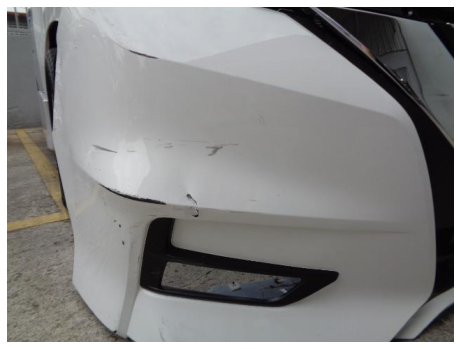

In [9]:
I = io.imread('%s/scratch/images/%s'%(dataDir,img['file_name']))
# use url to load image
# I = io.imread(img['scalabel_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

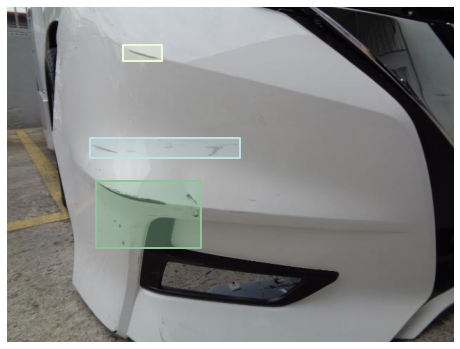

In [10]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

## Caculate features

In [3]:
def compute_area(seg):
    seg = np.array(seg).reshape(-1,2).astype(np.int32)
    area = cv2.contourArea(seg)
    if area == 0:
        area = 1e-5
    return area


In [11]:
coco.areas_seg = {}
coco.areas_bbox = {}
coco.mask_box_ratio = {}
coco.mask_image_ratio = {}
coco.box_image_ratio = {}

# for ann in coco.dataset['annotations']:
#     if ann['image_id'] == 5519:
#         print(compute_area(ann['segmentation']))    

for ann in coco.dataset['annotations']:
    coco.areas_seg[ann['id']] = compute_area(ann['segmentation'])
    coco.areas_bbox[ann['id']] = ann['bbox'][2] * ann['bbox'][3] if ann['bbox'][2] * ann['bbox'][3] > 0 else 1e-5
    
    for img in coco.dataset['images']:
        if ann['image_id'] == img['id']:
            img_area = img['width'] * img['height']
    
    coco.mask_box_ratio[ann['id']] = coco.areas_seg[ann['id']]/coco.areas_bbox[ann['id']]
    coco.mask_image_ratio[ann['id']] = coco.areas_seg[ann['id']]/img_area
    coco.box_image_ratio[ann['id']] = coco.areas_bbox[ann['id']]/img_area



In [12]:
print(coco.areas_seg[7341], coco.areas_bbox[7341])
print(len(coco.areas_seg), len(coco.areas_bbox))

80.0 72.6638973560331
185348 185348


In [25]:
print(type(coco.mask_image_ratio))

<class 'dict'>


In [13]:
#save features
df_data = pd.DataFrame({'annotation_id': coco.areas_seg.keys(),'seg_area': coco.areas_seg.values(), 'bbox_area': coco.areas_bbox.values(), 
                        'mask_box_ratio': coco.mask_box_ratio.values(),'mask_image_ratio': coco.mask_image_ratio.values(),
                       'box_image_ratio': coco.box_image_ratio.values()})
df_data["area_bin"] = pd.cut(df_data["mask_image_ratio"],
                bins=[0, 5.000000000000013e-05, 0.2, df_data["seg_area"].max()],
                labels=["Small", "Medium", "Large"])

In [14]:
df_data

,annotation_id,seg_area,bbox_area,mask_box_ratio,mask_image_ratio,box_image_ratio,area_bin
0,1,1265.0,1292.594514,0.978652,0.004118,0.004208,Medium
1,2,6235.0,6298.427300,0.989930,0.020296,0.020503,Medium
2,3,14550.0,14421.478822,1.008912,0.047363,0.046945,Medium
3,4,1045.0,1021.173524,1.023332,0.003402,0.003324,Medium
4,5,51678.0,51762.843120,0.998361,0.168223,0.168499,Medium
...,...,...,...,...,...,...,...
185343,185346,1819.0,1758.453068,1.034432,0.005921,0.005724,Medium
185344,185347,5100.0,5164.656800,0.987481,0.016602,0.016812,Medium
185345,185348,798.0,803.438105,0.993231,0.002598,0.002615,Medium
185346,185349,3082.0,3092.112809,0.996729,0.010033,0.010065,Medium


In [15]:
df_data.to_csv('statistical_charts/merimen_scratch_report.csv',index=False)

## Plot data

In [ ]:
#load data from csv file
data = pd.read_csv('statistical_charts/merimen_scratch_report.csv')
print('data shape', data.shape)
data


array([[<AxesSubplot:title={'center':'annotation_id'}>,
        <AxesSubplot:title={'center':'seg_area'}>],
       [<AxesSubplot:title={'center':'bbox_area'}>,
        <AxesSubplot:title={'center':'mask_box_ratio'}>],
       [<AxesSubplot:title={'center':'mask_image_ratio'}>,
        <AxesSubplot:title={'center':'box_image_ratio'}>]], dtype=object)

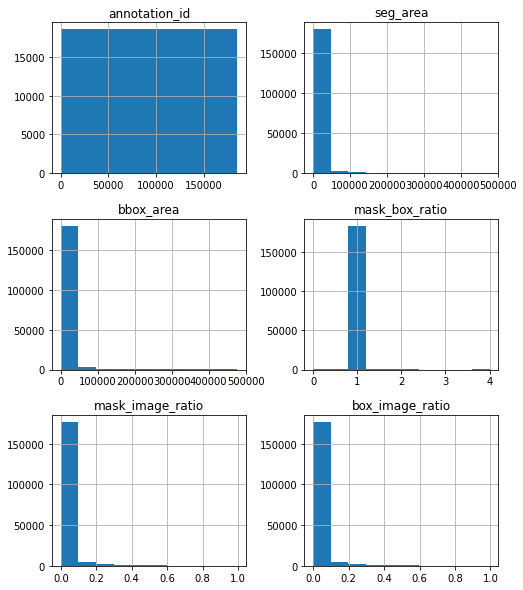

In [17]:
data.hist()

Text(0, 0.5, 'pixel2')

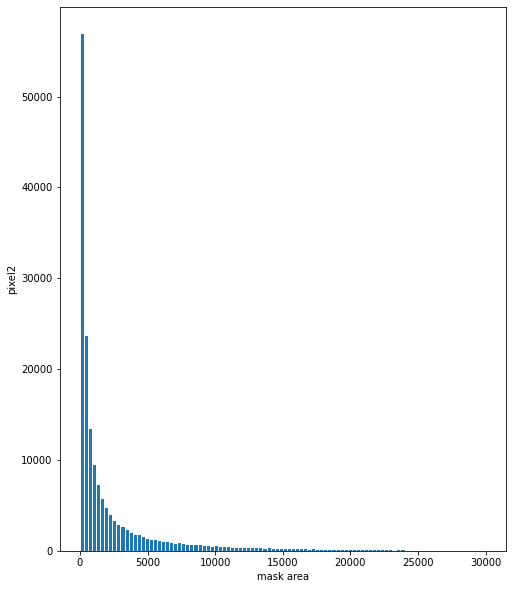

In [22]:
plt.hist(data[data.seg_area<3e4].seg_area, 100, edgecolor='w')
plt.xlabel('mask area')
plt.ylabel('pixel2')

Text(0, 0.5, 'pixel2')

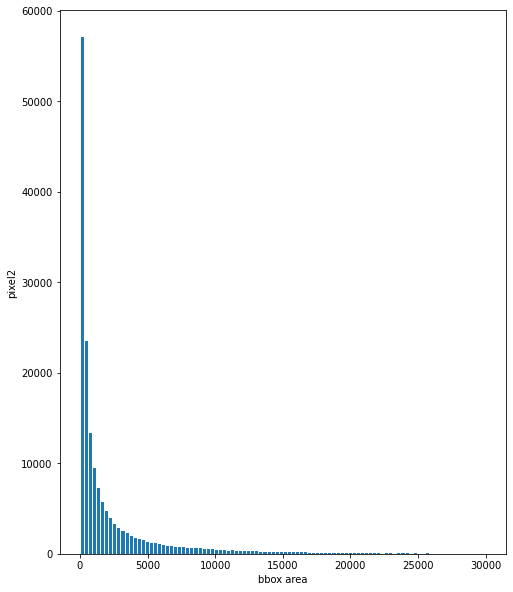

In [27]:
plt.hist(data[data.bbox_area<3e4].bbox_area, 100, edgecolor='w')
plt.xlabel('bbox area')
plt.ylabel('pixel2')

Text(0.5, 0, 'mask box ratio')

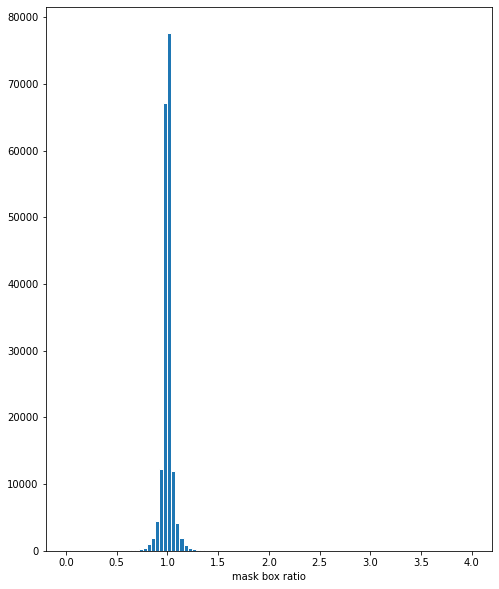

In [38]:
plt.hist(data.mask_box_ratio, 100, edgecolor='w')
plt.xlabel('mask box ratio')

Text(0.5, 0, 'mask image ratio')

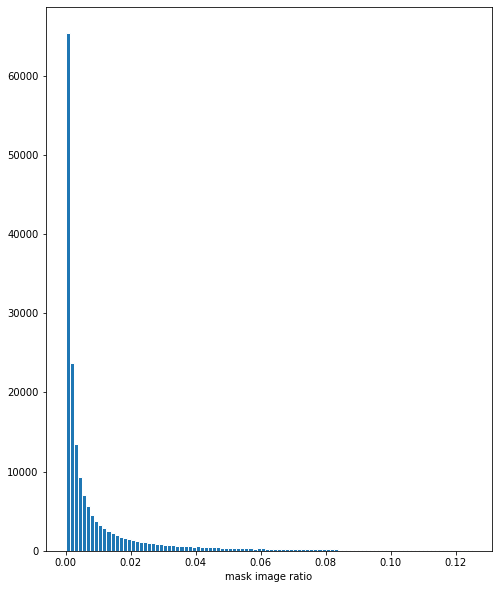

In [31]:
plt.hist(data[data.box_image_ratio<0.125].box_image_ratio, 100, edgecolor='w')
plt.xlabel('mask image ratio')

Text(0.5, 0, 'mask image ratio')

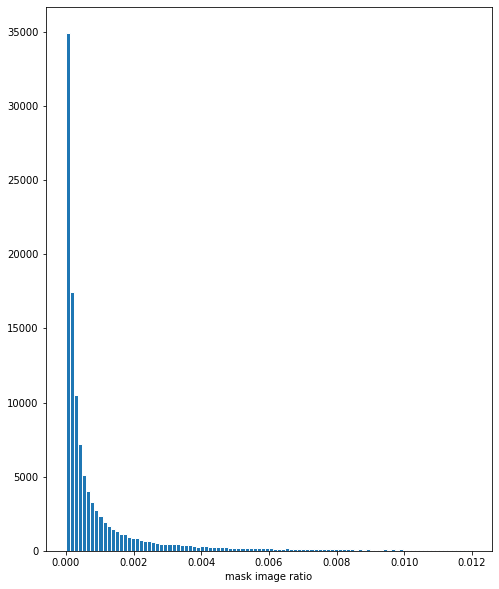

In [67]:
plt.hist(data[data.mask_image_ratio<0.012].mask_image_ratio, 100, edgecolor='w')
plt.xlabel('mask image ratio')

# Try to clean data

In [7]:
#load data from csv file
data = pd.read_csv('statistical_charts/merimen_scratch_report.csv')
print('data shape', data.shape)
data

data shape (185348, 8)


,annotation_id,seg_area,image_id,bbox_area,mask_box_ratio,mask_image_ratio,box_image_ratio,area_bin
0,1,1265.0,0,1292.594514,0.978652,0.004118,0.004208,Medium
1,2,6235.0,0,6298.427300,0.989930,0.020296,0.020503,Medium
2,3,14550.0,0,14421.478822,1.008912,0.047363,0.046945,Medium
3,4,1045.0,1,1021.173524,1.023332,0.003402,0.003324,Medium
4,5,51678.0,2,51762.843120,0.998361,0.168223,0.168499,Medium
...,...,...,...,...,...,...,...,...
185343,185346,1819.0,90296,1758.453068,1.034432,0.005921,0.005724,Medium
185344,185347,5100.0,90297,5164.656800,0.987481,0.016602,0.016812,Medium
185345,185348,798.0,90297,803.438105,0.993231,0.002598,0.002615,Medium
185346,185349,3082.0,90297,3092.112809,0.996729,0.010033,0.010065,Medium


In [4]:
print(data.shape[0])

185348


In [8]:
data.describe()

,annotation_id,seg_area,image_id,bbox_area,mask_box_ratio,mask_image_ratio,box_image_ratio
count,185348.000000,185348.000000,185348.000000,185348.000000,1.853480e+05,1.853480e+05,1.853480e+05
mean,92676.488864,6579.528981,44908.766078,6587.001525,9.994342e-01,2.127292e-02,2.129668e-02
std,53505.522365,20888.418630,26113.136541,20910.072966,5.585908e-02,6.681172e-02,6.687980e-02
min,1.000000,0.000010,0.000000,0.000010,4.846952e-11,2.083333e-11,2.083333e-11
25%,46339.750000,210.000000,22068.750000,213.269777,9.861854e-01,6.835937e-04,6.930664e-04
50%,92676.500000,858.000000,45272.500000,857.000808,1.000000e+00,2.792318e-03,2.786401e-03
75%,139013.250000,3827.000000,67326.250000,3834.396356,1.012922e+00,1.246094e-02,1.248176e-02
max,185350.000000,477204.000000,90297.000000,477511.391374,3.999855e+00,9.947982e-01,9.948154e-01


## clean tiny and huge scratch based on segmentation area 

mean  6579.528980627577     std  20888.418629707005


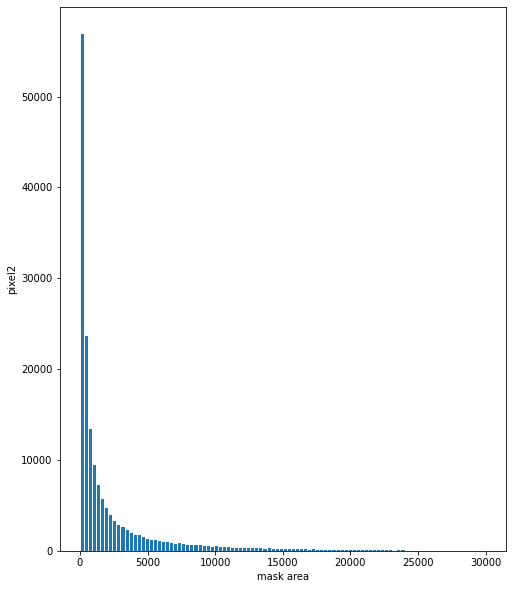

In [33]:
plt.hist(data[data.seg_area<3e4].seg_area, 100, edgecolor='w')
plt.xlabel('mask area')
plt.ylabel('pixel2')

seg_area_mean = data.seg_area.mean()
seg_area_std = data.seg_area.std()
print('mean ', seg_area_mean, '    std ', seg_area_std)

#### Inference: standard deviation>> the mean ==> the distribution of seg's area is strongly skewed and overdispersed and heavy tailed. Mean is biased by outliers => Better measures of location are the median.

#### define upper, lower limit

upper_limit 27467.94761033458 ==> 9909 upper outliers
lower_limit 176               ==> 40344 lower outliers
data frame shape (134648, 8)  <=>  remove 50700 outliers
percentage of outliers: 27.354 %


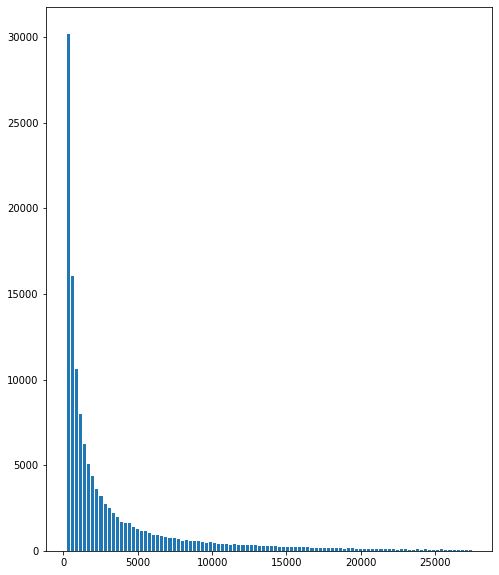

In [38]:
# remove area_seg > mean + 0.5 * std. After visualizing the mask of one of the filtered outliers, 
#I saw that the damage with area: 76507.0 is not much large. so I'm gonna move z-score far away toward the right.
#so I will remove area_seg > mean + 2*std, then visualize to see if the coefficient of 2 is fine?

upper_limit = seg_area_mean + 1*seg_area_std
lower_limit = 176
print('upper_limit', upper_limit, '==> {} upper outliers'.format(data[data.seg_area>upper_limit].shape[0]))
print('lower_limit', lower_limit, '              ==> {} lower outliers'.format(data[data.seg_area<lower_limit].shape[0]))
data_removed_seg_outliers = data[(data.seg_area<upper_limit)&(data.seg_area>lower_limit)]
print('data frame shape', data_removed_seg_outliers.shape, ' <=>  remove {} outliers'.format(data.shape[0]-data_removed_seg_outliers.shape[0]))
n, bins, _ = plt.hist(data_removed_seg_outliers.seg_area, 100, edgecolor='w')

print('percentage of outliers: {:.3f} %'.format(100*(1-data_removed_seg_outliers.shape[0]/data.shape[0])))

### draw a random filtered outlier above upper limit

In [39]:
upper_seg_area_outlier = data[(data.seg_area>=upper_limit)]
print('number of upper outliers', upper_seg_area_outlier.shape[0])

number of upper outliers 9909


annoId 57580      area: 28638.0
(4, 1, 2)
<class 'list'>


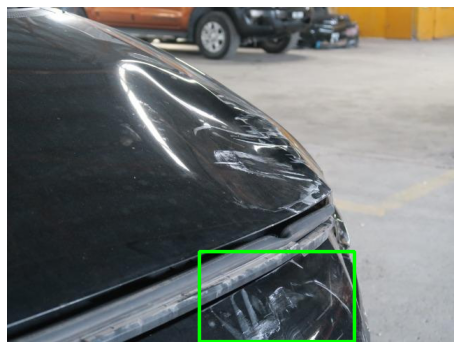

In [42]:
sample = upper_seg_area_outlier.sample(n=1)
# print(sample)
annoId = sample.annotation_id.iloc[0]
seg_area = sample.seg_area.iloc[0]
print('annoId', annoId, '     area:', seg_area)
#get image id
for ann in coco.anns.values():
    if ann['id'] == annoId:
        imgId = ann['image_id']
        seg = ann['segmentation']
        break
#get image name
for img in coco.imgs.values():
    if img['id'] == imgId:
        image = img
        img_name = img['file_name']
        break

        
I = io.imread('%s/scratch/images/%s'%(dataDir,img_name))

plt.axis('off')
plt.imshow(I)
seg = np.array(seg).reshape(-1,1,2)
print((seg.shape))
print(type([seg]))

#get and contour from the segmentation
shape = I.copy()
cv2.drawContours(shape, [seg.astype(int)], -1, (0,255,0), 3)
plt.imshow(shape)

### conclusion: filtering tiny and huge scratch image based on damage's area seems fruitless because the images are not the same size. So, intuitively we need to filter outliers based on correlation between damage area and image or car area.
damage_area/image_area ratio is considered following.

## clean tiny and huge scratches based on segmentation area/image area ratio

In [2]:
data = pd.read_csv('statistical_charts/merimen_scratch_report.csv')


ratio mean  0.021272921513757353     std  0.066811722879267
ratio max  0.9947981770833332      ratio min  2.0833333333333336e-11


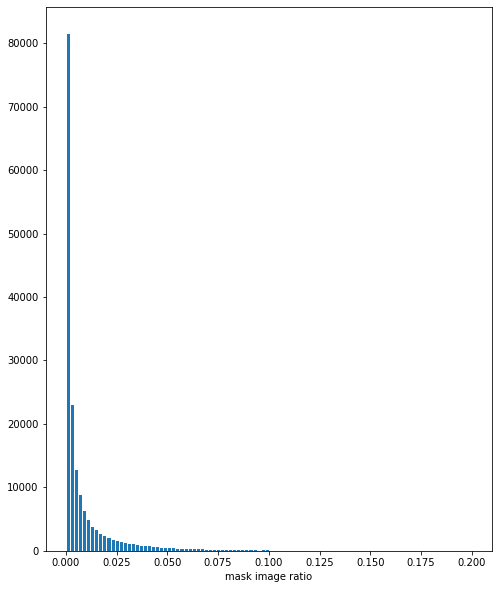

In [3]:
plt.hist(data[data.mask_image_ratio<0.2].mask_image_ratio, 100, edgecolor='w')
plt.xlabel('mask image ratio')

ratio_mean = data.mask_image_ratio.mean()
ratio_std = data.mask_image_ratio.std()
ratio_min = data.mask_image_ratio.min()
ratio_max = data.mask_image_ratio.max()
print('ratio mean ', ratio_mean, '    std ', ratio_std)
print('ratio max ', ratio_max, '     ratio min ', ratio_min)

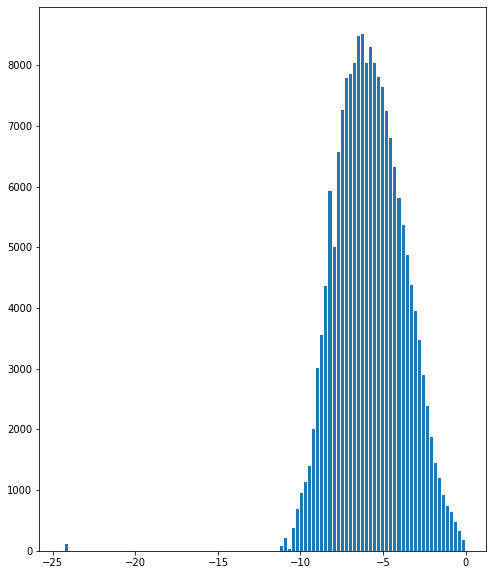

In [4]:
# log-transformation: a new viewpoint
log_ratio = np.log(data.mask_image_ratio)
n, bins, _ = plt.hist(log_ratio, bins=100, edgecolor='w')

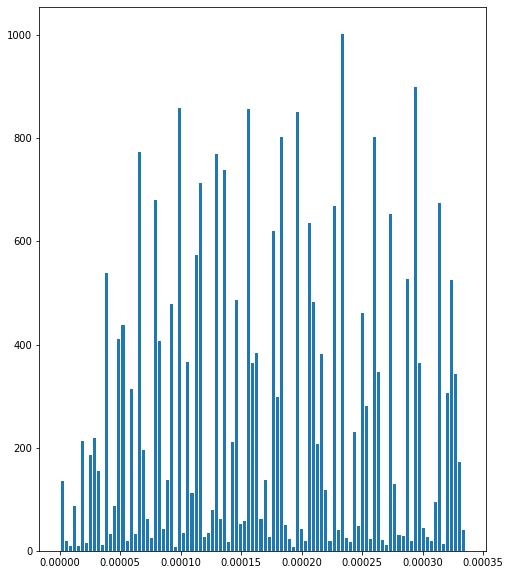

In [92]:
demo_lower_limit = np.exp(-8)
under_lower_ratio_outlier = data[(data.mask_image_ratio<=demo_lower_limit)]

n,bins,_ = plt.hist(under_lower_ratio_outlier.mask_image_ratio, bins=100, edgecolor='w')

### define filtering coefficients and save outlier data to a new data frame

In [110]:
#define upper filtering coefficients (z-score threshold)
#this coefficient need to be iteratively adjusted to be fit well to specificity of the data

#it's similar to finding a z-score threshold, which is defined as the number of standard deviations away xi is from the mean
upper_coefficient = (0.1- ratio_mean)/ratio_std

# define upper and lower limit 
upper_limit = ratio_mean + upper_coefficient*ratio_std
lower_limit = np.exp(-8.5)
print('upper_limit', upper_limit)
print('lower_limit', lower_limit)

upper_limit 0.1
lower_limit 0.00020346836901064417


In [116]:


#save outlier data in order to visualize, then investigate and adjust filtering coefficients
clean_data = data[(data.mask_image_ratio>lower_limit) & (data.mask_image_ratio<upper_limit)]
under_lower_ratio_outliers = data[(data.mask_image_ratio<=lower_limit)]
above_upper_ratio_outliers = data[(data.mask_image_ratio>=upper_limit)]

no_outliers = data.shape[0]-clean_data.shape[0]
print('shape of clean data frame: ', clean_data.shape, '<=>  remove {} outliers'.format(no_outliers))
print('precentage of total outliers: {:.3f} %'.format((no_outliers/data.shape[0])*100))
print('precentage of tiny outliers: {:.3f} %'.format((under_lower_ratio_outliers.shape[0]/data.shape[0])*100))
print('precentage of huge outliers: {:.3f} % annotations <=> remove {:.3f}% images'.format((above_upper_ratio_outliers.shape[0]/data.shape[0])*100,(above_upper_ratio_outliers.shape[0]/len(coco.imgs))*100) )

# n, bins, _ = plt.hist(data_remove_outliers.mask_image_ratio, 100, edgecolor='w')


shape of clean data frame:  (161035, 11) <=>  remove 24313 outliers
precentage of total outliers: 13.117 %
precentage of tiny outliers: 8.407 %
precentage of huge outliers: 4.710 % annotations <=> remove 9.668% images


In [112]:
print('number of under outliers', under_lower_ratio_outliers.shape[0])

print('number of above outliers', above_upper_ratio_outliers.shape[0])

number of under outliers 15583
number of above outliers 8730


In [105]:
def draw_samples(data, num=3):
    
    samples = data.sample(n=num**2)
    print(samples.shape)
    fig, axis = plt.subplots(num, num, figsize=(15,15))
    for i in range(samples.shape[0]):
        sample = samples.iloc[i,]
        annoId = sample.annotation_id
        seg_area = sample.seg_area
        seg_image_ratio = sample.mask_image_ratio

        print('annoId', annoId, '     area:', seg_area, '    ratio', seg_image_ratio)
        
        #get image id
        for ann in coco.anns.values():
            if ann['id'] == annoId:
                imgId = ann['image_id']
                seg = ann['segmentation']
                break
        #get image name
        for img in coco.imgs.values():
            if img['id'] == imgId:
                image = img
                img_name = img['file_name']
                break
        I = io.imread('%s/scratch/images/%s'%(dataDir,img_name))
        seg = np.array(seg).reshape(-1,1,2)        
        shape = I.copy()
        cv2.drawContours(shape, [seg.astype(int)], -1, (0,255,0), 2)

        axis[int(i/num), i%num].imshow(shape)

### draw a random filtered outlier under lower limit

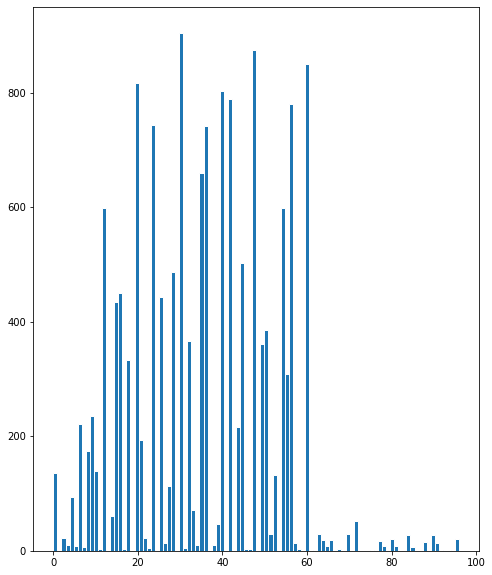

In [106]:
n,bins,_ = plt.hist(under_lower_ratio_outliers.seg_area, bins=100, edgecolor='w')

(9, 11)
annoId 125735      area: 9.0     ratio 2.9296875e-05
annoId 44838      area: 20.0     ratio 6.510416666666667e-05
annoId 112636      area: 15.0     ratio 4.893006263048017e-05
annoId 169369      area: 20.0     ratio 7.335680751173709e-05
annoId 175437      area: 52.0     ratio 0.0001692708333333
annoId 120434      area: 30.0     ratio 9.765625e-05
annoId 95083      area: 32.0     ratio 0.0001041666666666
annoId 47481      area: 63.0     ratio 0.00013125
annoId 59716      area: 48.0     ratio 0.00015625


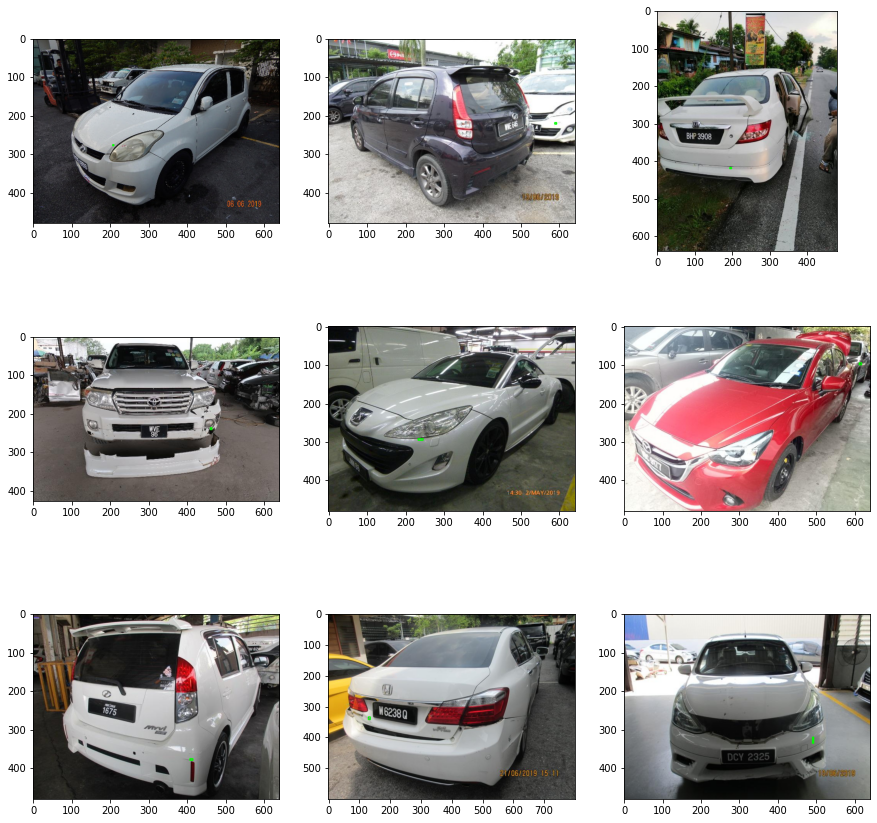

In [107]:
draw_samples(under_lower_ratio_outlier, num=3)

### draw a random filtered outlier above upper limit

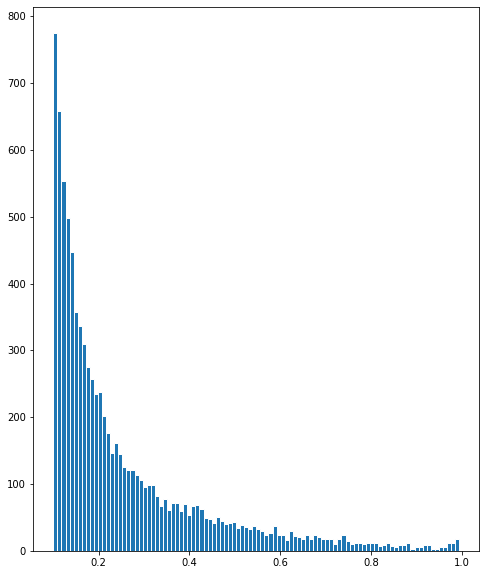

In [113]:
n,bins,_ = plt.hist(above_upper_ratio_outliers.mask_image_ratio, bins=100, edgecolor='w')

(9, 11)
annoId 38049      area: 64032.0     ratio 0.2084375
annoId 44880      area: 46620.0     ratio 0.1517578125
annoId 149622      area: 51756.0     ratio 0.1684765625
annoId 780      area: 245604.0     ratio 0.7994921875
annoId 118389      area: 88638.0     ratio 0.28853515625
annoId 39743      area: 477204.0     ratio 0.994175
annoId 21212      area: 64740.0     ratio 0.2107421875
annoId 121725      area: 46716.0     ratio 0.1520703125
annoId 172074      area: 120576.0     ratio 0.3925


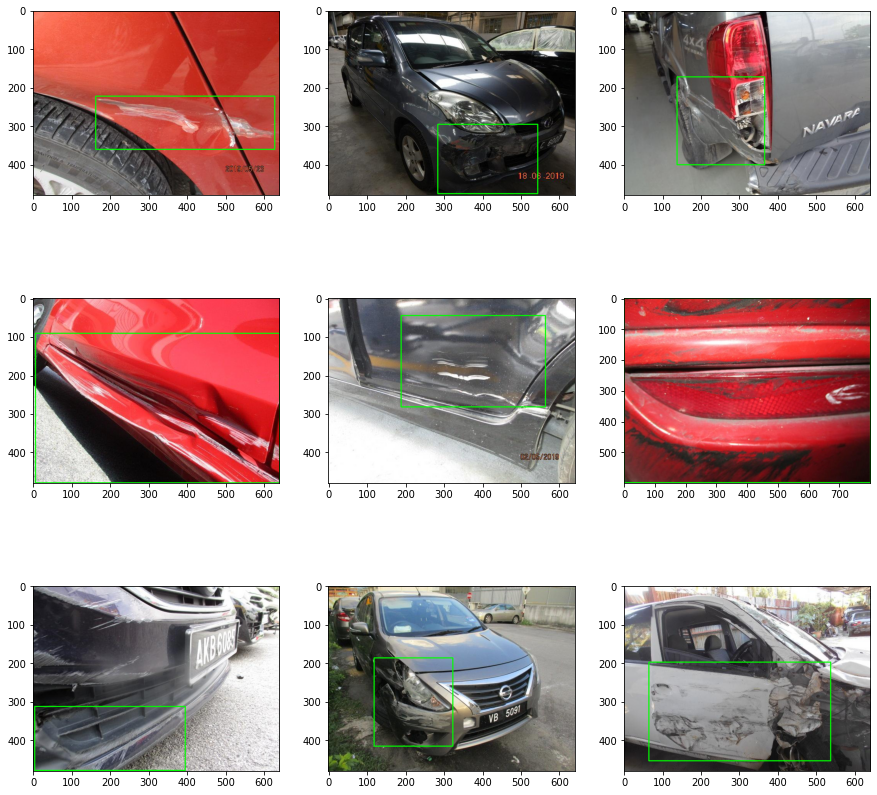

In [117]:
draw_samples(above_upper_ratio_outlier, num=3)

## clean tiny and huge scratches based on both segmentation's area and its area/image area ratio

In [84]:
# limit of seg area
area_upper_limit = seg_area_mean + 1*seg_area_std
area_lower_limit = 176

#limit of ratio
#define lower, upper filtering coefficients. These coefficients need to be iteratively adjusted to be fit well to specificity of the data

lower_coefficient = (ratio_mean - 1e-5)/ratio_std
upper_coefficient = (0.2- ratio_mean)/ratio_std
print(lower_coefficient, upper_coefficient)

# define upper and lower limit 
ratio_upper_limit = ratio_mean + upper_coefficient*ratio_std
ratio_lower_limit = ratio_mean - lower_coefficient*ratio_std
print('ratio_upper_limit', ratio_upper_limit)
print('ratio_lower_limit', ratio_lower_limit)

0.31825135765740986 2.6750856104880545
ratio_upper_limit 0.2
ratio_lower_limit 9.999999999999593e-06


In [85]:
#save outlier data in order to visualize, then investigate and adjust filtering coefficients
under_lower_ratio_outlier = data[(data.mask_image_ratio<ratio_lower_limit) & (data.seg_area<area_lower_limit)]
above_upper_ratio_outlier = data[(data.mask_image_ratio>ratio_upper_limit) & (data.seg_area>area_upper_limit)]
frames = [under_lower_ratio_outlier, above_upper_ratio_outlier]
data_outliers = pd.concat(frames)


print('shape of outliers data frame: ', data_outliers.shape, '<=>  remove {} outliers'.format(data_outliers.shape[0]))
print('precentage of total outliers: {:.3f} %'.format((data_outliers.shape[0]/data.shape[0])*100))
print('precentage of tiny outliers: {:.3f} %'.format((under_lower_ratio_outlier.shape[0]/data.shape[0])*100))
print('precentage of huge outliers: {:.3f} %'.format((above_upper_ratio_outlier.shape[0]/data.shape[0])*100))

# n, bins, _ = plt.hist(data_remove_outliers.mask_image_ratio, 100, edgecolor='w')

shape of outliers data frame:  (4154, 7) <=>  remove 4154 outliers
precentage of total outliers: 2.241 %
precentage of tiny outliers: 0.092 %
precentage of huge outliers: 2.149 %


area_upper_limit = seg_area_mean + 1*seg_area_std
area_lower_limit = 176

ratio_upper_limit 0.2
ratio_lower_limit 9.999999999999593e-06


#remove outliers with both seg's area & seg/img ratio thresholds
shape of outliers data frame:  (4154, 7) <=>  remove 4154 outliers
precentage of total outliers: 2.241 %
precentage of tiny outliers: 0.092 %
precentage of huge outliers: 2.149 %
    
#remove outliers with only seg/img ratio thresholds
shape of outliers data frame:  (4154, 7) <=>  remove 4154 outliers
precentage of total outliers: 2.241 %
precentage of tiny outliers: 0.092 %
precentage of huge outliers: 2.149 %

#### conclution: the conditional combination of seg's area and seg/img ratio is fruitless because we have the same results when considering only seg/img ratio and both seg's area and seg/img ratio

## clean tiny and huge scratches based on car's area and seg/image area ratio

### car_mask_data understanding

In [23]:
json_path='../data/coco_datasets/datasets/merimen_coco/19_02_2022/scratch/annotations/total_car.json'
car_mask_data = json.load(open(json_path))

In [25]:
print('number of infered images with car model: ', len(car_mask_data['images']))
print('number of infered images with scratch model: ', len(coco.dataset['images']))

print('number of annotations with car model: ', len(car_mask_data['annotations']))
print('number of annotations with scratch model: ', len(coco.dataset['annotations']))


number of infered images with car model:  90298
number of infered images with scratch model:  90298
number of annotations with car model:  325222
number of annotations with scratch model:  185348


In [26]:
img_to_scratch_anns = defaultdict(list)
for ann in coco.dataset['annotations']:
    img_to_scratch_anns[ann['image_id']].append(ann)

In [27]:
img_to_car_anns = defaultdict(list)
for ann in car_mask_data['annotations']:
    img_to_car_anns[ann['image_id']].append(ann)

In [118]:
print(len(img_to_car_anns))
print(len(car_mask_data['images']))
print('number of images without annotation: ', len(car_mask_data['images']) - len(img_to_car_anns))

85442
90298
number of images without annotation:  4856


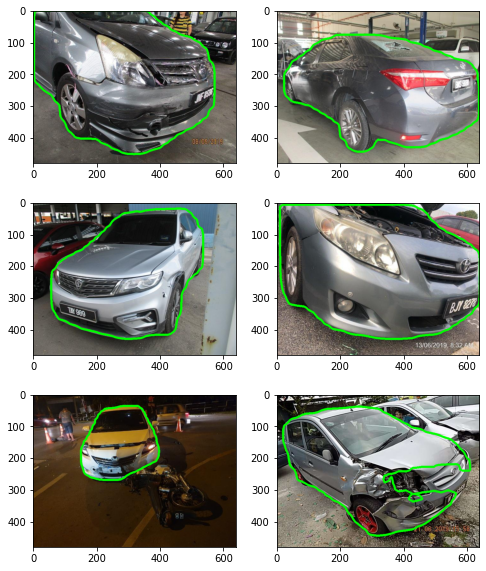

In [27]:
#plot the bigest mask on the first six images
fig = plt.figure()
for i,img in enumerate(car_mask_data['images'][:6]):
    img_id = img['id']
    img_name = img['file_name']
    image = io.imread('%s/scratch/images/%s'%(dataDir,img_name))
    
    fig.add_subplot(3,2,i+1)
    plt.imshow(image)
    
    if img_id in img_to_car_anns.keys():
        anns = img_to_car_anns[img_id]
        shape = image.copy()
        max_seg = None
        max_area = 0
        for ann in anns:
            seg = ann['segmentation']
            area = compute_area(seg)
            if area>max_area:
                max_area = area
                max_seg = seg
        max_seg = np.array(max_seg).reshape(-1,1,2)
            
        cv2.drawContours(shape, [max_seg.astype(int)], -1, (0,255,0), 5)
        plt.imshow(shape)

plt.show()
    

### calculate scratch_car_ratio feature

In [124]:
scratch_data_dir = '../data/coco_datasets/datasets/merimen_coco/19_02_2022'
dataType = 'total'
scratch_ann_file = '{}/scratch/annotations/{}.json'.format(scratch_data_dir,dataType)
scratch_mask_data = json.load(open(scratch_ann_file))

car_mask_path = '../data/coco_datasets/datasets/merimen_coco/19_02_2022/scratch/annotations/total_car_v2.json'
car_mask_data = json.load(open(car_mask_path))

In [133]:
img_to_scratch_anns = defaultdict(list)
for ann in scratch_mask_data['annotations']:
    img_to_scratch_anns[ann['image_id']].append(ann)

img_to_car_anns = defaultdict(list)
for ann in car_mask_data['annotations']:
    img_to_car_anns[ann['image_id']].append(ann)

print('Number of images without car mask annotation: ', len(car_mask_data['images'])-len(img_to_car_anns))

Number of images without car mask annotation:  4856


In [214]:
print(img_to_car_anns[39129][0]['id'])

26845


In [173]:
print(len(img_to_car_anns))
print(len(scratch_mask_data['images']))
print(len(img_to_car_anns.values()))

85442
90298
85442


In [ ]:
def compute_area(seg):
    seg = np.array(seg).reshape(-1,2).astype(np.int32)
    area = cv2.contourArea(seg)
    if area == 0:
        area = 1e-5
    return area

def draw_binary_mask(seg, img_shape):
    seg = np.array(seg).reshape(-1,2)
    polygon = np.array(seg)
    mask = draw.polygon2mask(img_shape,polygon)
    return mask
def intersection_check(original_image, cnt1, cnt2):
    img_shape = original_image.shape[:2]
    mask1 = draw_binary_mask(cnt1, img_shape)
    mask2 = draw_binary_mask(cnt2, img_shape)
    intersection = np.logical_and(mask1, mask2)
    return intersection.any()

carmask_area = {}
carmask_id = {}
scratch_car_ratio = {}

for img in tqdm(car_mask_data['images']):
    img_name = img['file_name']
    image = io.imread('%s/scratch/images/%s'%(scratch_data_dir,img_name))
    img_id = img['id']

    scratch_anns = img_to_scratch_anns[img_id]
    car_anns = img_to_car_anns[img_id]
    
    if len(car_anns) == 0:
        car_anns = [{'id': img_id, 'segmentation': [0,0, img['width'],0, img['width'],img['height'], 0, img['height']]}]
    for scratch_ann in scratch_anns:
        scratch_ann_id = scratch_ann['id']
        scratch_seg = scratch_ann['segmentation']
        scratch_area = compute_area(scratch_seg)

        for car_ann in car_anns:
            car_ann_id = car_ann['id']
            car_seg = car_ann['segmentation']

            if intersection_check(image, scratch_seg, car_seg):
                car_area = compute_area(car_seg)                
            else:
                car_area = img['width']*img['height']
            ratio = scratch_area/car_area

            carmask_area[scratch_ann_id] = car_area
            carmask_id[scratch_ann_id] = car_ann_id
            scratch_car_ratio[scratch_ann_id] = ratio

print(len(carmask_area), len(carmask_id), len(scratch_car_ratio))

feature_table = pd.read_csv('statistical_charts/merimen_scratch_report.csv')
feature_table['carmask_area'] = carmask_area.values()
feature_table['carmask_id'] = carmask_id.values()
feature_table['scratch_car_ratio'] = scratch_car_ratio.values()

feature_table.to_csv('statistical_charts/merimen_scratch_report.csv', index=False)

In [199]:
data = pd.read_csv('statistical_charts/merimen_scratch_report.csv')
data

,annotation_id,seg_area,image_id,bbox_area,mask_box_ratio,mask_image_ratio,box_image_ratio,area_bin,carmask_area,carmask_id,scratch_car_ratio
0,1,1265.0,0,1292.594514,0.978652,0.004118,0.004208,Medium,201539.0,0,0.266087
1,2,6235.0,0,6298.427300,0.989930,0.020296,0.020503,Medium,201539.0,0,0.010246
2,3,14550.0,0,14421.478822,1.008912,0.047363,0.046945,Medium,201539.0,0,0.000546
3,4,1045.0,1,1021.173524,1.023332,0.003402,0.003324,Medium,201539.0,0,0.000625
4,5,51678.0,2,51762.843120,0.998361,0.168223,0.168499,Medium,165407.0,4,0.004679
...,...,...,...,...,...,...,...,...,...,...,...
185343,185346,1819.0,90296,1758.453068,1.034432,0.005921,0.005724,Medium,307200.0,325220,0.002552
185344,185347,5100.0,90297,5164.656800,0.987481,0.016602,0.016812,Medium,307200.0,325220,0.001582
185345,185348,798.0,90297,803.438105,0.993231,0.002598,0.002615,Medium,307200.0,325220,0.001325
185346,185349,3082.0,90297,3092.112809,0.996729,0.010033,0.010065,Medium,227012.5,325221,0.144448


ratio mean  0.03660111322855883     std  0.6774580314270913
ratio max  186.339016074038      ratio min  2.0833333333333336e-11


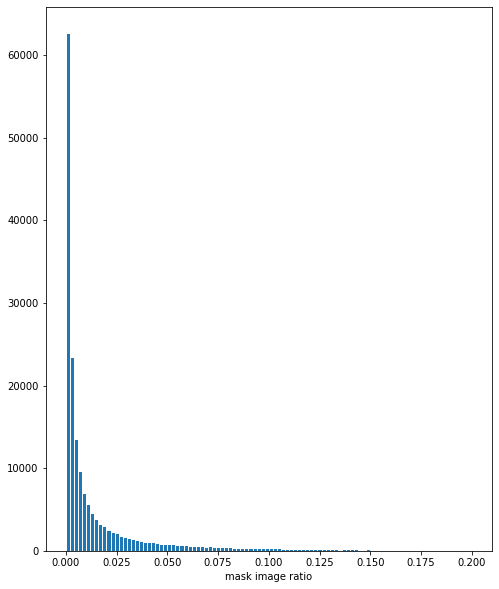

In [121]:
plt.hist(data[data.scratch_car_ratio<0.2].scratch_car_ratio, 100, edgecolor='w')
plt.xlabel('mask image ratio')

ratio_mean = data.scratch_car_ratio.mean()
ratio_std = data.scratch_car_ratio.std()
ratio_min = data.scratch_car_ratio.min()
ratio_max = data.scratch_car_ratio.max()
print('ratio mean ', ratio_mean, '    std ', ratio_std)
print('ratio max ', ratio_max, '     ratio min ', ratio_min)

In [231]:
def draw_samples_v2(df, num=3):
    
    samples = df.sample(n=num)
#     print(samples)
    fig, axis = plt.subplots(num, num, figsize=(15,15))
    
    for i in range(samples.shape[0]):
        sample = samples.iloc[i,]
        
        scratch_annoId = sample.annotation_id
        seg_area = sample.seg_area
        seg_image_ratio = sample.mask_image_ratio
        scratch_car_ratio = sample.scratch_car_ratio
        img_id = sample.image_id
        car_mask_id = sample.carmask_id
        car_anns = img_to_car_anns[img_id]
        
        print(img_id,scratch_annoId,car_mask_id)
        #get image name
        for img in scratch_mask_data['images']:
            if img['id'] == img_id:
                image = img
                img_name = img['file_name']
                break
        I = io.imread('%s/scratch/images/%s'%(dataDir,img_name))
        
        
        if len(car_anns) == 0:
            car_anns = [{'id': img_id, 'segmentation': [0,0, img['width'],0, img['width'],img['height'], 0, img['height']]}]
            
#       get scratchmask    
        for ann in img_to_scratch_anns[img_id]:
            if ann['id'] == scratch_annoId:
                scratchmask = np.array(ann['segmentation']).reshape(-1,2).astype(int)
                break
        print(scratchmask)
        cv2.drawContours(I, [scratchmask], -1, (255,0,0), 2)
        
        
        
        car_annos = [np.array(ann['segmentation']).reshape(-1,2).astype(np.int32) for ann in car_mask_data['annotations'] if ann['image_id']==img_id]
        I = cv2.drawContours(I,car_annos,-1,(0,255,0),2)
        
        car_ann = img_to_car_anns[img_id][0]
        carmask = np.array(car_ann['segmentation']).reshape(-1,1,2).astype(int)
        cv2.drawContours(I, carmask, -1, (0,0,255), 2)
        plt.imshow(I)
            
#         print('annoId', scratch_annoId, '     area:', seg_area, '   scratch/img ratio', seg_image_ratio,'scratch/car ratio', scratch_car_ratio, 'image id', img_id)
#         print('no car annos in an image', len(img_to_car_anns[img_id]))
        
            
#         for car_ann in car_anns:
#             print(car_ann['id'], carmask_id, img_id)
#             if car_ann['id'] == carmask_id:
#                 carmask = np.array(car_ann['segmentation']).reshape(-1,2).astype(int)
#                 break
#         print(carmask)
                
                
        

       
# #         shape = I.copy()
# #         cv2.drawContours(shape, [carmask], -1, (0,255,0), 2)
# #         cv2.drawContours(shape, [scratchmask], -1, (255,0,0), 2)

# #         axis[int(i/num), i%num].imshow(shape)

(135, 11)
24239 50883 88608
[[283 206]
 [258 206]
 [258 252]
 [283 252]]


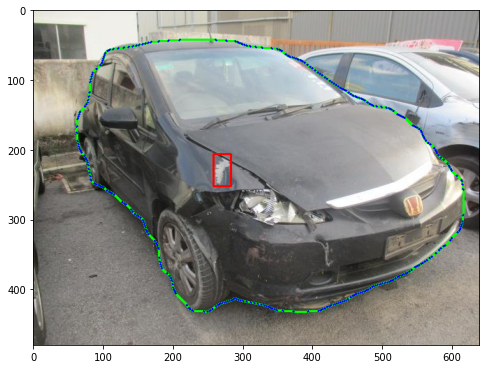

In [233]:
# ratio > 1
anomal_ratio = data[data.scratch_car_ratio>1]
print(anomal_ratio.shape)
draw_samples_v2(anomal_ratio)

In [270]:
duplicate_feature = {}
img_id = {}
for ann in scratch_mask_data['annotations']:
    duplicate_feature[ann['id']] = ann['image_id']
    img_id[ann['id']] = ann['image_id']
draft_df = pd.DataFrame({'anno_id': duplicate_feature.keys(), 'image_id': img_id.values(), 'duplicate_img_id': duplicate_feature.values()})
keys = (list(img_id.keys()))
values1 = list(x for x in draft_df["image_id"])
values2 = list(x for x in draft_df["duplicate_img_id"])
values3 = list(x for x in draft_df["anno_id"])

# print(draft_df['anno_id'])
print(keys == values3)
print((values1==values2))

True
True


In [ ]:
df_data = pd.DataFrame({'annotation_id': coco.areas_seg.keys(),'seg_area': coco.areas_seg.values(), 'bbox_area': coco.areas_bbox.values(), 
                        'mask_box_ratio': coco.mask_box_ratio.values(),'mask_image_ratio': coco.mask_image_ratio.values(),
                       'box_image_ratio': coco.box_image_ratio.values()})
df_data["area_bin"] = pd.cut(df_data["mask_image_ratio"],
                bins=[0, 5.000000000000013e-05, 0.2, df_data["seg_area"].max()],
                labels=["Small", "Medium", "Large"])

In [271]:
data = pd.read_csv('statistical_charts/merimen_scratch_report_v2.csv')
data

,annotation_id,seg_area,image_id,bbox_area,mask_box_ratio,mask_image_ratio,box_image_ratio,area_bin,carmask_area,carmask_id,scratch_car_ratio,scratch_car_ratio_v2
0,1,1265.0,0,1292.594514,0.978652,0.004118,0.004208,Medium,201539.0,0,0.266087,0.004118
1,2,6235.0,0,6298.427300,0.989930,0.020296,0.020503,Medium,201539.0,0,0.010246,0.020296
2,3,14550.0,0,14421.478822,1.008912,0.047363,0.046945,Medium,201539.0,0,0.000546,0.047363
3,4,1045.0,1,1021.173524,1.023332,0.003402,0.003324,Medium,201539.0,0,0.000625,0.003402
4,5,51678.0,2,51762.843120,0.998361,0.168223,0.168499,Medium,165407.0,4,0.004679,0.204071
...,...,...,...,...,...,...,...,...,...,...,...,...
185343,185346,1819.0,90296,1758.453068,1.034432,0.005921,0.005724,Medium,307200.0,325220,0.002552,0.010145
185344,185347,5100.0,90297,5164.656800,0.987481,0.016602,0.016812,Medium,307200.0,325220,0.001582,0.025947
185345,185348,798.0,90297,803.438105,0.993231,0.002598,0.002615,Medium,307200.0,325220,0.001325,0.004060
185346,185349,3082.0,90297,3092.112809,0.996729,0.010033,0.010065,Medium,227012.5,325221,0.144448,0.015680


554.2562584220408

In [109]:
def draw_scratch(img_id, image):
    
    anns = [ann for ann in coco.dataset['annotations'] if ann['image_id']==img_id]
    for ann in anns:
        seg = ann['segmentation']
        seg = np.array(seg).reshape(-1,1,2)
        shape = image.copy()
        cv2.drawContours(shape, seg.astype(int), -1, (0,255,0),3)
    return shape
def draw_carmask(carmask_anno_id, image):
    for ann in car_mask_data['annotations']:
        if ann['id'] == carmask_anno_id:
            
            seg = ann['segmentation']
            seg = np.array(seg).reshape(-1,1,2)
            cv2.drawContours(image, seg.astype(int), -1, (255,0,0),3)
            break
    return image

SyntaxError: invalid syntax (2976514345.py, line 12)

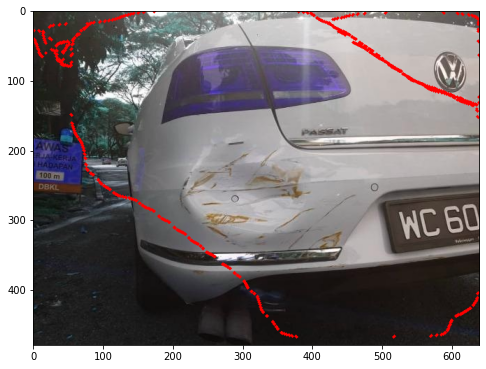

In [110]:
# plot the most extreme mask/carmask outliers
carmask_annotation_id = data.loc[data.scratch_carmask_ratio==data.scratch_carmask_ratio.max(), 'annotation_id'].values[0]
img_id = data.loc[data.scratch_carmask_ratio==data.scratch_carmask_ratio.max(), 'image_id'].values[0]
for img in car_mask_data['images']:
    if img['id']==img_id:
        img_name = img['file_name']
        break
image = cv2.imread('%s/scratch/images/%s'%(dataDir,img_name))
scratch_image = draw_scratch(img_id,image)
plt.imshow(draw_carmask(carmask_annotation_id, image))

In [ ]:
data.del